## Importing libraries and dataset

Importing necessary libraries

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression,Ridge,Lasso,SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler

Reading the dataset

In [3]:
boston_df=pd.read_csv("boston.csv")
print(boston_df.head())
boston_df.RAD.describe()

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2  


count    506.000000
mean       9.549407
std        8.707259
min        1.000000
25%        4.000000
50%        5.000000
75%       24.000000
max       24.000000
Name: RAD, dtype: float64

## Performing EDA on the dataset

Identifying correlations

In [4]:
correlation_matrix=boston_df.corr()
correlation_coefficient=correlation_matrix.loc["MEDV"]
print(correlation_coefficient)

CRIM      -0.388305
ZN         0.360445
INDUS     -0.483725
CHAS       0.175260
NOX       -0.427321
RM         0.695360
AGE       -0.376955
DIS        0.249929
RAD       -0.381626
TAX       -0.468536
PTRATIO   -0.507787
B          0.333461
LSTAT     -0.737663
MEDV       1.000000
Name: MEDV, dtype: float64


We can observe that there is a higher positive correlation of MEDV with RM and negative with LSTAT. Now, we would try to visualize these coefficients using barplot and then look at the corelations of MEDV with RM and LSTAT using a scatterplot

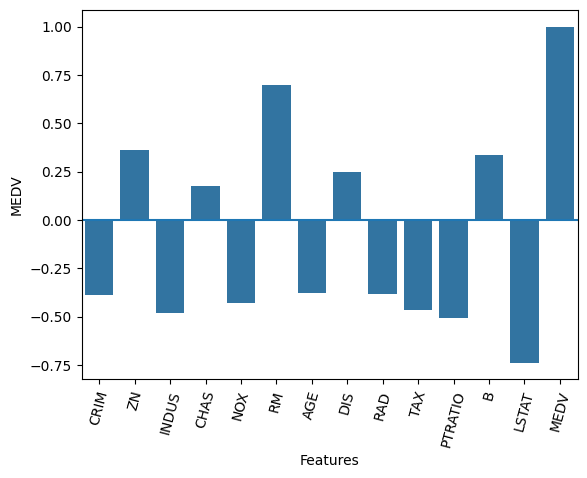

In [5]:
sns.barplot(x=correlation_coefficient.index,y=correlation_coefficient)
plt.xticks(rotation=75)
plt.xlabel("Features")
plt.axhline(y=0)

<Axes: xlabel='MEDV', ylabel='RM'>

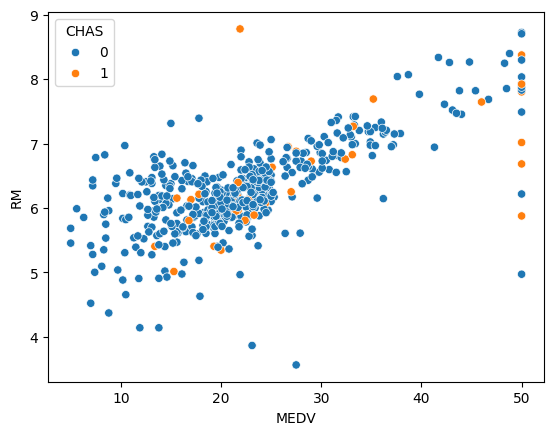

In [6]:
sns.scatterplot(data=boston_df,x="MEDV",y="RM",hue="CHAS")
# sns.scatterplot(data=boston_df,x="MEDV",y="LSTAT")

<Axes: xlabel='MEDV', ylabel='LSTAT'>

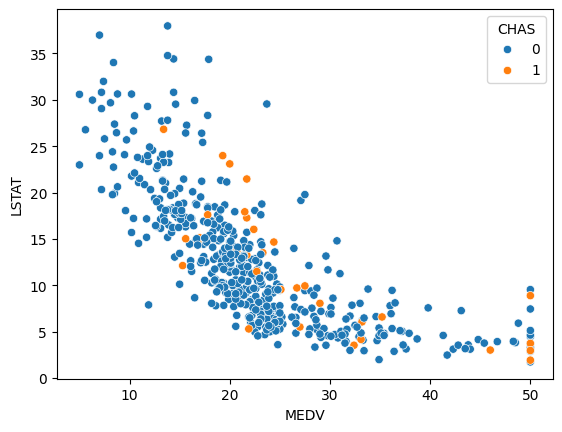

In [7]:
sns.scatterplot(data=boston_df,x="MEDV",y="LSTAT",hue="CHAS")

From the plots above, we can further confirm that RM and LSTAT play a crucial role in the determination of MEDV. An interesting observation was found that there was a vertical straight line in both the plots at the highest point of the MEDV. This signifies that there are certain areas where the prices are high irrespective of any of these two factors. We can also infer that the CHAS parameter does not play a significant role in the price of houses.

Now let us observe the distribution of the prices of houses in Boston

<Axes: xlabel='MEDV', ylabel='Count'>

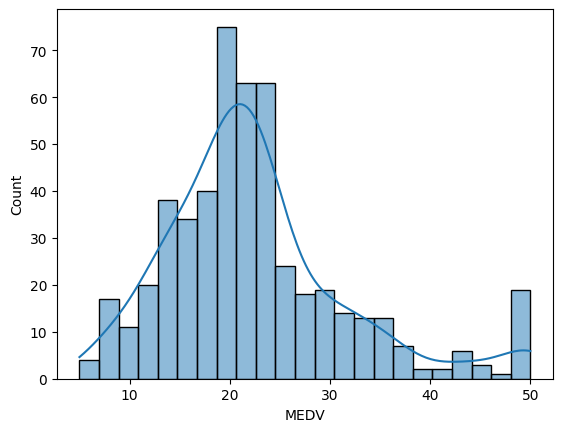

In [8]:
sns.histplot(data=boston_df["MEDV"],kde=True)

From this curve we can infer that the prices follow a distribution similar to that of a normal distribution. High number of regions show a price range of around 15-25k dollars and this number decreases on both sides of the curve. There are a significant number of areas where the price is the maximum i.e. upto 50K dollars.

## Data Preprocessing

Before training our models, we need to ensure that the data is processed and can be presented in a structured manner. This process involves multiple functions such as splitting the dataset into training and testing sets, scaling the input parameters and handling missing values. 

Splitting the dataset

In [10]:
boston_df_train,boston_df_test=train_test_split(boston_df,test_size=0.2,random_state=42,shuffle=True,stratify=boston_df["RAD"])

We have two categorical columns; CHAS and RAD. Thus we would like these variables to be distributed in equal proportion in both the testing and training sets. Since the RAD parameter is more influential in deciding the prices as compared to CHAS, we have stratified the RAD column. This is important as we do not want higher values of RAD in one set and lower values in the other. 

In [11]:
boston_df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 404 entries, 174 to 123
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     404 non-null    float64
 1   ZN       404 non-null    float64
 2   INDUS    404 non-null    float64
 3   CHAS     404 non-null    int64  
 4   NOX      404 non-null    float64
 5   RM       404 non-null    float64
 6   AGE      404 non-null    float64
 7   DIS      404 non-null    float64
 8   RAD      404 non-null    int64  
 9   TAX      404 non-null    float64
 10  PTRATIO  404 non-null    float64
 11  B        404 non-null    float64
 12  LSTAT    404 non-null    float64
 13  MEDV     404 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 47.3 KB


In [12]:
boston_df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102 entries, 150 to 170
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     102 non-null    float64
 1   ZN       102 non-null    float64
 2   INDUS    102 non-null    float64
 3   CHAS     102 non-null    int64  
 4   NOX      102 non-null    float64
 5   RM       102 non-null    float64
 6   AGE      102 non-null    float64
 7   DIS      102 non-null    float64
 8   RAD      102 non-null    int64  
 9   TAX      102 non-null    float64
 10  PTRATIO  102 non-null    float64
 11  B        102 non-null    float64
 12  LSTAT    102 non-null    float64
 13  MEDV     102 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 12.0 KB


In [13]:
boston_df_train.RAD.value_counts()

RAD
24    105
5      92
4      88
3      30
6      21
2      19
8      19
1      16
7      14
Name: count, dtype: int64

In [14]:
boston_df_test.RAD.value_counts()

RAD
24    27
5     23
4     22
3      8
6      5
2      5
8      5
1      4
7      3
Name: count, dtype: int64

We can observe the equal distribution of the RAD values in the testing and training sets.

Scaling the inputs: Since the ranges of all the input parameters are different, there can be a discrepancy when the model assigns weights to the inputs while predicting the final values. Hence we would scale the inputs by using standardization to ensure that all the ranges lie between -1 to 1.

In [15]:
scaler=StandardScaler()
scaled_data=scaler.fit_transform(boston_df_train[["CRIM","ZN","INDUS","NOX","RM","AGE","DIS","TAX","PTRATIO","B","LSTAT"]])
categorical_df=boston_df_train[["CHAS","RAD"]]
scaled_boston_df=pd.DataFrame(scaled_data,columns=["CRIM","ZN","INDUS","NOX","RM","AGE","DIS","TAX","PTRATIO","B","LSTAT"],index=categorical_df.index)
scaled_inputs_df=scaled_boston_df.join(categorical_df)
print(scaled_inputs_df.head())


         CRIM       ZN     INDUS       NOX        RM       AGE       DIS  \
174 -0.438036 -0.48816 -1.031222 -0.388492 -0.590447  0.014193 -0.504206   
121 -0.439743 -0.48816  2.079384  0.218856 -0.387969  0.557932 -0.745213   
395  0.711619 -0.48816  0.992112  1.176925  0.264147  1.076955 -0.970552   
444  1.255736 -0.48816  0.992112  1.578972 -0.597429  0.999278 -0.889388   
334 -0.444307 -0.48816 -0.867052 -0.345721  0.039327 -1.052100  1.290330   

          TAX   PTRATIO         B     LSTAT  CHAS  RAD  
174 -0.675607 -0.880758  0.411715 -0.428416     0    5  
121 -1.316129  0.282985  0.246214  0.212796     0    2  
395  1.518774  0.795032  0.398420  0.607494     0   24  
444  1.518774  0.795032 -1.212555  1.531227     0   24  
334 -1.102622  0.795032  0.370978 -0.828654     0    5  


In [16]:
scaler=StandardScaler()
scaled_data_test=scaler.fit_transform(boston_df_test[["CRIM","ZN","INDUS","NOX","RM","AGE","DIS","TAX","PTRATIO","B","LSTAT"]])
categorical_df_test=boston_df_test[["CHAS","RAD"]]
scaled_boston_df_test=pd.DataFrame(scaled_data_test,columns=["CRIM","ZN","INDUS","NOX","RM","AGE","DIS","TAX","PTRATIO","B","LSTAT"],index=categorical_df_test.index)
scaled_inputs_df_test=scaled_boston_df_test.join(categorical_df_test)
print(scaled_inputs_df_test.head())
print(scaled_inputs_df_test.info())

         CRIM        ZN     INDUS       NOX        RM       AGE       DIS  \
150 -0.244114 -0.486262  1.349292  2.872896 -0.270395  1.012729 -1.088319   
53  -0.379014  0.393074 -0.803676 -1.015747 -0.463406 -1.769410  1.342845   
496 -0.358882 -0.486262 -0.178172  0.298470 -1.409783  0.118339 -0.536000   
1   -0.380903 -0.486262 -0.582819 -0.745703  0.195010  0.338271  0.478485   
183 -0.374794 -0.486262 -1.294813 -0.574674  0.416039  0.950415 -0.513358   

          TAX   PTRATIO         B     LSTAT  CHAS  RAD  
150  0.008441 -1.631156  0.096809  0.260754     0    5  
53  -0.948249 -0.682490  0.403783 -0.576723     0    4  
496 -0.063310  0.401699  0.403783  1.300585     0    6  
1   -0.954229 -0.230745  0.403783 -0.471854     0    2  
183 -1.247215 -0.230745  0.403783 -0.982907     0    3  
<class 'pandas.core.frame.DataFrame'>
Index: 102 entries, 150 to 170
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     102

## Model Selection

We now move on to the most important part of the project. Here we would be analyzing various regression models with the help of parameters such as mean squared error and cross validation score and try to come up with the best model which would give us accurate predictions of the house prices in Boston.  

In [17]:
def model_evaluation(model):
    targets=boston_df_train["MEDV"]
    model.fit(scaled_inputs_df,targets)
    predictions=model.predict(scaled_inputs_df)
    rmse=np.sqrt(mean_squared_error(targets,predictions))
    cv_scores=np.sqrt(-cross_val_score(model,scaled_inputs_df,targets,cv=10,scoring="neg_mean_squared_error"))
    cv_score=np.mean(cv_scores)
    print(f"RMSE training: {rmse}")
    print(f"Cross-val score training: {cv_score}")

# targets=boston_df_train["MEDV"]
# print(targets.info())
# print(scaled_inputs_df.info())
    

In [18]:
def model_evaluation_test(model):
    targets_test=boston_df_test["MEDV"]
    model.fit(scaled_inputs_df_test,targets_test)
    predictions_test=model.predict(scaled_inputs_df_test)
    rmse=np.sqrt(mean_squared_error(targets_test,predictions_test))
    cv_scores=np.sqrt(-cross_val_score(model,scaled_inputs_df_test,targets_test,cv=10,scoring="neg_mean_squared_error"))
    cv_score=np.mean(cv_scores)
    print(f"RMSE test: {rmse}")
    print(f"Cross-val score test: {cv_score}")

We have calculated the mean squared error using two different methods: using the in-built function and using cross-validation. Cross-validation gives a much more accurate value than the in-built function in those cases where there are chances of the model overfitting the dataset. In such cases the in-built function would give out a mean squared error of zero. 

In [19]:
model=LinearRegression()
model_evaluation(model)
model_evaluation_test(model)

RMSE training: 4.206793512297368
Cross-val score training: 4.430301307401366
RMSE test: 5.297349243986835
Cross-val score test: 6.523760067159086


In [20]:
model=Ridge()
model_evaluation(model)
model_evaluation_test(model)

RMSE training: 4.206879957610888
Cross-val score training: 4.426357995558213
RMSE test: 5.305183778981306
Cross-val score test: 6.309289354569918


In [21]:
model=Lasso()
model_evaluation(model)
model_evaluation_test(model)

RMSE training: 4.855214004607843
Cross-val score training: 4.958280600069428
RMSE test: 6.591543092345639
Cross-val score test: 6.9298099192297595


In [22]:
model=SGDRegressor()
model_evaluation(model)
model_evaluation_test(model)

RMSE training: 4.527929639991953
Cross-val score training: 4.787182074575549
RMSE test: 6.708821133197627
Cross-val score test: 7.631899901551518


In [23]:
model=DecisionTreeRegressor()
model_evaluation(model)
model_evaluation_test(model)

RMSE training: 0.0
Cross-val score training: 4.176497713191337
RMSE test: 0.0
Cross-val score test: 5.474699720907181


In [24]:
model=RandomForestRegressor()
model_evaluation(model)
model_evaluation_test(model)

RMSE training: 1.241671028521366
Cross-val score training: 3.2362653691512135
RMSE test: 1.8984107104339136
Cross-val score test: 4.565801184772565


In [25]:
model=ExtraTreesRegressor()
model_evaluation(model)
model_evaluation_test(model)

RMSE training: 3.276387898539392e-14
Cross-val score training: 3.0210396472288483
RMSE test: 2.996319935379901e-14
Cross-val score test: 4.045041807130664


In [28]:
model=XGBRegressor()
model_evaluation(model)
model_evaluation_test(model)

RMSE training: 0.016197838124055966
Cross-val score training: 3.3179746800546135
RMSE test: 0.0010479220060682557
Cross-val score test: 6.223395241966221


## HyperParametric Tuning

By looking at the results we can observe that the RandomForestRegressor, ExtraTreesRegressor and XGBoost offer the best values for the evaluation metric. However the ExtraTreesRegressor and XGBoost models show overfitting as they have rmse values very close to zero and also show a large difference in the cross-validation scores. Now we will try to improve these models using hyperparametric tuning

In [ ]:
parameters={
    "n_estimators": [100,300,500],
    "max_depth": [1,3,5]
}
targets=boston_df_train["MEDV"]
clf=GridSearchCV(RandomForestRegressor(),parameters)
clf.fit(scaled_inputs_df,targets)

In [ ]:
parameters={
    "n_estimators": [100,300,500],
    "max_depth": [1,3,5]
}
targets=boston_df_train["MEDV"]
clf=GridSearchCV(ExtraTreesRegressor(),parameters)
clf.fit(scaled_inputs_df,targets)

In [ ]:
parameters={
    "n_estimators": [100,300,500],
    "max_depth": [1,3,5]
}
targets=boston_df_train["MEDV"]
clf=GridSearchCV(XGBRegressor(),parameters)
clf.fit(scaled_inputs_df,targets)

In [27]:
new_random_forest_model=RandomForestRegressor(n_estimators=500,max_depth=5)
model_evaluation(new_random_forest_model)
model_evaluation_test(new_random_forest_model)

RMSE training: 2.2370138646553124
Cross-val score training: 3.4620502275447778
RMSE test: 2.233154925939579
Cross-val score test: 4.522738952851066


In [39]:
new_extra_trees_model=ExtraTreesRegressor(n_estimators=500,max_depth=5)
model_evaluation(new_extra_trees_model)
model_evaluation_test(new_extra_trees_model)

RMSE training: 2.458133784085273
Cross-val score training: 3.3855776155777106
RMSE test: 1.9349871071830336
Cross-val score test: 4.25424044382425


In [44]:
new_xgboost_model=XGBRegressor(n_estimators=300,max_depth=5)
model_evaluation(new_xgboost_model)
model_evaluation_test(new_xgboost_model)

RMSE training: 0.0014369111322522854
Cross-val score training: 3.2675336058903865
RMSE test: 0.001058737744485411
Cross-val score test: 5.9379501292546895


## Conclusion

We observe that after performing the hyper parameteric tuning, it is the ExtraTrees regressor which shows the optimal values of the cross validation scores. Thus this model can be used to make predictions of the housing prices in Boston. 